In [1]:
import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 

# Reconnaissance de signaux de communication par apprentissage profond

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur 
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie 
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié. 

L'émetteur peut provenir de 6 catégories différentes. 
Les paramètres différenciant les différentes catégories sont 
- le type de modulation 
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données 
- le débit de la transmission 

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0. 


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation 
électromagnétique comme : 
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données). 
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont: 

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet. 
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones". 

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données : 
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones 
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage 
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [2]:
data_path = 'samples.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [3]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données 

Commencez par étudier les données: 

    - observez leur taille 
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement 
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez 

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering 

Taille de signals : (200, 2048, 2)


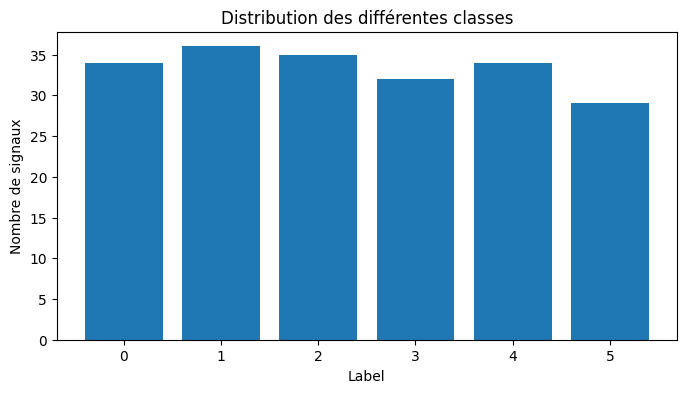

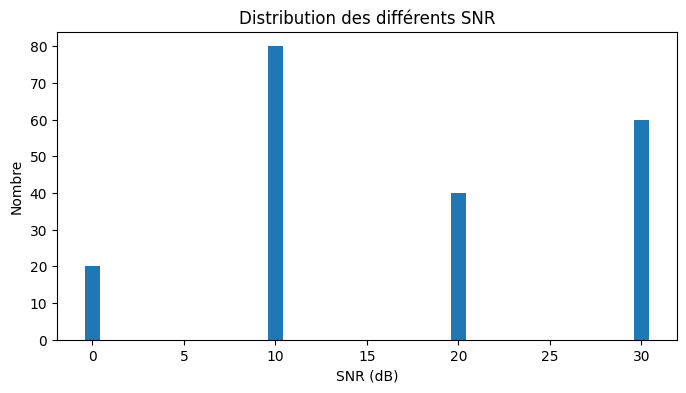

In [4]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Taille des données
print(f"Taille de signals : {signals.shape}")

# Distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
liste_labels, nb_labels = np.unique(labels_id, return_counts=True)
plt.figure(figsize=(8, 4))
plt.bar(liste_labels, nb_labels)
plt.xlabel('Label')
plt.ylabel('Nombre de signaux')
plt.title('Distribution des différentes classes')
plt.show()

# Distribution of different SNR
liste_snr, nb_snr = np.unique(snr, return_counts=True)
plt.figure(figsize=(8, 4))
plt.bar(liste_snr, nb_snr)
plt.xlabel('SNR (dB)')
plt.ylabel('Nombre')
plt.title('Distribution des différents SNR')
plt.show()

In [5]:
# Visualisation de signaux
def plot_signal(signal_index):
    df_signal = signals[signal_index]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))
    
    ax1.plot(df_signal[:, 0])
    ax1.set_title('In Phase')

    ax2.plot(df_signal[:, 1])
    ax2.set_title('Quadrature')

    fig.suptitle(f'Signal {signal_index} - Label: {labels_id[signal_index]}, SNR: {snr[signal_index]} dB')
    plt.tight_layout()
    plt.show()

signal_slider = widgets.IntSlider(min=0, max=len(signals)-1, step=1, value=0, description="Index du signal")
widgets.interact(plot_signal, signal_index=signal_slider)

interactive(children=(IntSlider(value=0, description='Index du signal', max=199), Output()), _dom_classes=('wi…

<function __main__.plot_signal(signal_index)>

In [6]:
def plot_in_phase_vs_quadrature(signal_index):
    df_signal = signals[signal_index]
    
    plt.figure(figsize=(8, 4))
    plt.scatter(df_signal[:, 0], df_signal[:, 1])
    plt.xlabel('In Phase')
    plt.ylabel('Quadrature')
    plt.title(f'Signal {signal_index} - In Phase vs. Quadrature')
    plt.grid(True)
    plt.show()

signal_slider = widgets.IntSlider(min=0, max=len(signals) - 1, step=1, value=0, description="Index du signal (Scatter)")
widgets.interact(plot_in_phase_vs_quadrature, signal_index=signal_slider)

interactive(children=(IntSlider(value=0, description='Index du signal (Scatter)', max=199), Output()), _dom_cl…

<function __main__.plot_in_phase_vs_quadrature(signal_index)>

## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch. 
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets : 
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones 
    
Un dataset prend la forme 
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici 

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        self.data = h5py.File(path_to_data, 'r')
        self.signals = np.array(self.data['signaux'])
        self.snr = np.array(self.data['snr'])
        self.labels_id = np.array(self.data['labels'])
        
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = self.signals[idx]
        label = self.labels_id[idx]
        return signal, label
    
    def get_labels(self):
        return {
            self.data['label_name'].attrs[k]: k
            for k in self.data['label_name'].attrs.keys()
        }


Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [8]:
data_path = 'samples.hdf5'

dataset = MyDataset(path_to_data = data_path)
print(dataset.__getitem__(1)[1])
data.close()

2


Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset. 
La cellule suivante donne un exemple d'utilisation

In [9]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, 
                        batch_size=10, 
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size 

In [10]:
batch_sizes = [1, 5, 10, 20, 50]

for batch_size in batch_sizes:
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(len(dataloader))
    for batch_x, batch_y in dataloader:
        print(f"Batch X shape: {batch_x.shape}, Batch Y shape: {batch_y.shape}")
        break 
    print()

200
Batch X shape: torch.Size([1, 2048, 2]), Batch Y shape: torch.Size([1])

40
Batch X shape: torch.Size([5, 2048, 2]), Batch Y shape: torch.Size([5])

20
Batch X shape: torch.Size([10, 2048, 2]), Batch Y shape: torch.Size([10])

10
Batch X shape: torch.Size([20, 2048, 2]), Batch Y shape: torch.Size([20])

4
Batch X shape: torch.Size([50, 2048, 2]), Batch Y shape: torch.Size([50])



## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier). 

Ce modèle doit comporter moins de 10000 paramètres libres. 

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Model1(nn.Module):
    def __init__(self, input_channels=2, num_classes=6, signal_length=2048):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=4, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3, stride=2, padding=1)
        reduced_length = signal_length // 4
        self.fc = nn.Linear(2 * reduced_length, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, T, C) -> (B, C, T)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées (test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point).

In [14]:
input_channels = 3  # C
num_classes = 5     # N
batch_size = 10     # B
time_steps = 100    # T
signal_length = 2048

model = Model1(input_channels=input_channels, num_classes=num_classes, signal_length=signal_length)
x = torch.randn(batch_size, signal_length, input_channels)
output = model(x)
print(output.shape)

torch.Size([10, 5])


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante : 

In [15]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

num_params = count_n_param(model)
print(f"Theoretical number of parameters: ?")
print(f"Actual number of parameters: {num_params}")

Theoretical number of parameters: ?
Actual number of parameters: 5191


In [16]:
# Calcul théorique :
# Conv1 : 2*4*3+4=28
# Conv2 : 4*2*3+2=26
# FC : 2*2048/4*6+6=6150
# Total : 6204

## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à 
- charger les données 
- les batcher 
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires 

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs. 

In [12]:
device = 'cpu'
model = Model1(input_channels=2, num_classes=6, signal_length=2048)
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

n_epochs = 10
chemin_vers_sauvegarde_model = "model.pth"
model.to(device)
loss_train = []
loss_validation = []

path_train = 'train.hdf5'
path_validation = 'validation.hdf5'
dataset_train = MyDataset(path_to_data = path_train)
dataset_validation = MyDataset(path_to_data = path_validation)

batch_size = 5
dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
dataloader_validation = DataLoader(dataset_validation, batch_size = batch_size, shuffle=True)

for epoch in range(n_epochs):
    loss_train_epoch = 0.0
    for batch_x, batch_y in dataloader_train:
        batch_x.to(device)
        # batch_y.to(device)
        batch_y = batch_y.to(device).long()
        optimizer.zero_grad()
        batch_y_predicted = model(batch_x)
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entrainement
        l.backward()
        optimizer.step()

        loss_train_epoch = loss_train_epoch + l.item()
    
    loss_train_epoch = loss_train_epoch/len(dataloader_train)
    loss_train.append(loss_train_epoch)

    loss_validation_epoch = 0.0
    for batch_x, batch_y in dataloader_validation:
        batch_x.to(device)
        # batch_y.to(device)
        batch_y = batch_y.to(device).long()
        with torch.no_grad():
            batch_y_predicted = model(batch_x)
            l = loss(batch_y_predicted, batch_y)
            loss_validation_epoch = loss_validation_epoch + l.item()
        # loggez les métriques sur le batch de validation
    loss_validation_epoch = loss_validation_epoch/len(dataloader_validation)
    loss_validation.append(loss_validation_epoch)

torch.save(model, chemin_vers_sauvegarde_model)

NameError: name 'Model1' is not defined

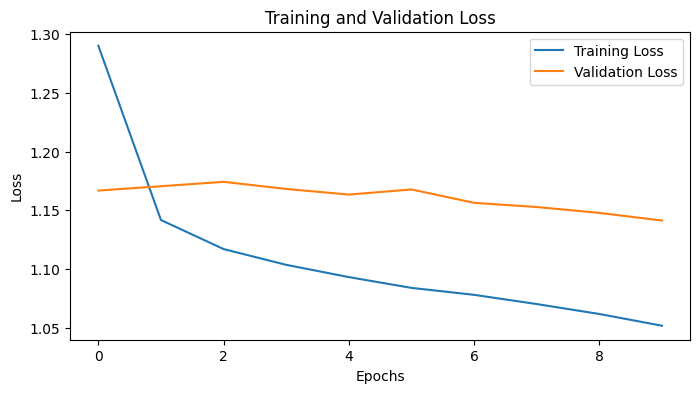

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(range(n_epochs), loss_train, label='Training Loss')
plt.plot(range(n_epochs), loss_validation, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction 
```python
modele = torch.load(...) 
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [40]:
modele = torch.load(chemin_vers_sauvegarde_model)

sample_signal = torch.tensor(signals[0:5], dtype=torch.float32)
sample_output = modele(sample_signal)
print(sample_output)

C:\Users\cyrie\AppData\Local\Temp\ipykernel_17556\1801127193.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modele = torch.load(chemin_vers_sauvegarde_model)


tensor([[-1.1584, -1.0769, -1.0711, -7.5907, -6.3667, -7.6692],
        [-1.3364, -1.0690, -0.9455, -6.6023, -6.4352, -6.0172],
        [-1.5385, -0.9892, -0.8854, -8.1449, -7.6524, -9.3479],
        [-7.5928, -8.5058, -8.7094, -1.3238, -0.8876, -1.1352],
        [-2.1502, -0.8057, -0.8298, -7.7526, -9.0656, -9.3768]],
       grad_fn=<LogSoftmaxBackward0>)


## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement. 
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches récurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps (facultatif), si vous le souhaitez vous pouvez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch. 

In [54]:
class Modele2(nn.Module):
    def __init__(self, input_channels=2, num_classes=6, signal_length=2048):
        super(Modele2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * (signal_length // 4), 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, T, C) -> (B, C, T)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Instantiate the model
device = 'cpu'
convnet_model = Modele2(input_channels=2, num_classes=6, signal_length=2048)
loss = nn.NLLLoss()
# optimizer = torch.optim.Adam(convnet_model.parameters())
optimizer = torch.optim.Adam(convnet_model.parameters(), weight_decay=1e-4)

n_epochs = 10
chemin_vers_sauvegarde_model = "model2.pth"
convnet_model.to(device)

batch_size = 10
path_train = 'train.hdf5'
path_validation = 'validation.hdf5'
dataset_train = MyDataset(path_to_data = path_train)
dataset_validation = MyDataset(path_to_data = path_validation)
dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
dataloader_validation = DataLoader(dataset_validation, batch_size = batch_size, shuffle=True)

loss_train = []
loss_validation = []
early_stopping_patience = 3
best_validation_loss = float('inf')
patience_counter = 0

for epoch in range(n_epochs):
    print(epoch)
    loss_train_epoch = 0.0
    convnet_model.train()
    for batch_x, batch_y in dataloader_train:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()
        optimizer.zero_grad()
        batch_y_predicted = convnet_model(batch_x)
        l = loss(batch_y_predicted, batch_y)
        l.backward()
        optimizer.step()
        loss_train_epoch = loss_train_epoch + l.item()
    
    loss_train_epoch = loss_train_epoch/len(dataloader_train)
    loss_train.append(loss_train_epoch)
    print("loss_train", loss_train_epoch)

    loss_validation_epoch = 0.0
    convnet_model.eval()
    with torch.no_grad():
        for batch_x, batch_y in dataloader_validation:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()
            batch_y_predicted = convnet_model(batch_x)
            l = loss(batch_y_predicted, batch_y)
            loss_validation_epoch = loss_validation_epoch + l.item()
    loss_validation_epoch = loss_validation_epoch/len(dataloader_validation)
    loss_validation.append(loss_validation_epoch)
    print("loss_valid", loss_validation_epoch)

    # Early Stopping
    if loss_validation_epoch < best_validation_loss:
        best_validation_loss = loss_validation_epoch
        patience_counter = 0
        torch.save(convnet_model.state_dict(), chemin_vers_sauvegarde_model)
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
torch.save(convnet_model, chemin_vers_sauvegarde_model)

0
loss_train 1.1291515348553658
loss_valid 0.7417500533759595
1
loss_train 0.6544303072243929
loss_valid 0.6422860052585602
2
loss_train 0.6009803610841433
loss_valid 0.6837706231921912
3
loss_train 0.5367544766316811
loss_valid 0.6779905592501163
4
loss_train 0.4462557251205047
loss_valid 0.8841965159475803
Early stopping triggered


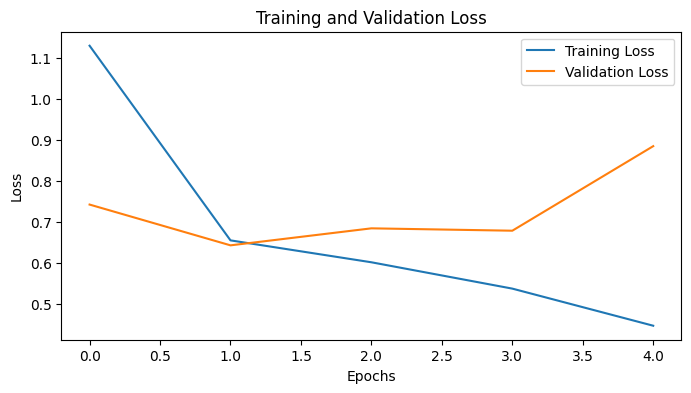

In [55]:
plt.figure(figsize=(8, 4))
plt.plot(range(5), loss_train, label='Training Loss')
plt.plot(range(5), loss_validation, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [33]:
modele = torch.load(chemin_vers_sauvegarde_model)

sample_signal = torch.tensor(signals[0:5], dtype=torch.float32)
sample_output = modele(sample_signal)
print(sample_output)

C:\Users\cyrie\AppData\Local\Temp\ipykernel_16612\1801127193.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modele = torch.load(chemin_vers_sauvegarde_model)


tensor([[-6.2136e+00, -8.3474e-01, -5.7268e-01, -3.5009e+01, -1.4423e+01,
         -1.4386e+01],
        [-5.7007e+00, -6.9179e-01, -7.0123e-01, -4.3424e+01, -1.9503e+01,
         -1.9275e+01],
        [-9.0397e+00, -3.3828e-01, -1.2487e+00, -4.7381e+01, -2.2704e+01,
         -2.2632e+01],
        [-1.6126e+01, -4.3985e+01, -2.8107e+01, -2.7224e-04, -9.2117e+00,
         -8.6666e+00],
        [-8.0788e+00, -6.5456e-01, -7.3393e-01, -4.6793e+01, -2.2415e+01,
         -2.2018e+01]], grad_fn=<LogSoftmaxBackward0>)


## Synthèse de résultats 

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec. 

C:\Users\cyrie\AppData\Local\Temp\ipykernel_16612\2990623529.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load(chemin_vers_sauvegarde_model)


Accuracy on test set: 0.6587
F1-score (macro): 0.6267
F1-score (micro): 0.6587


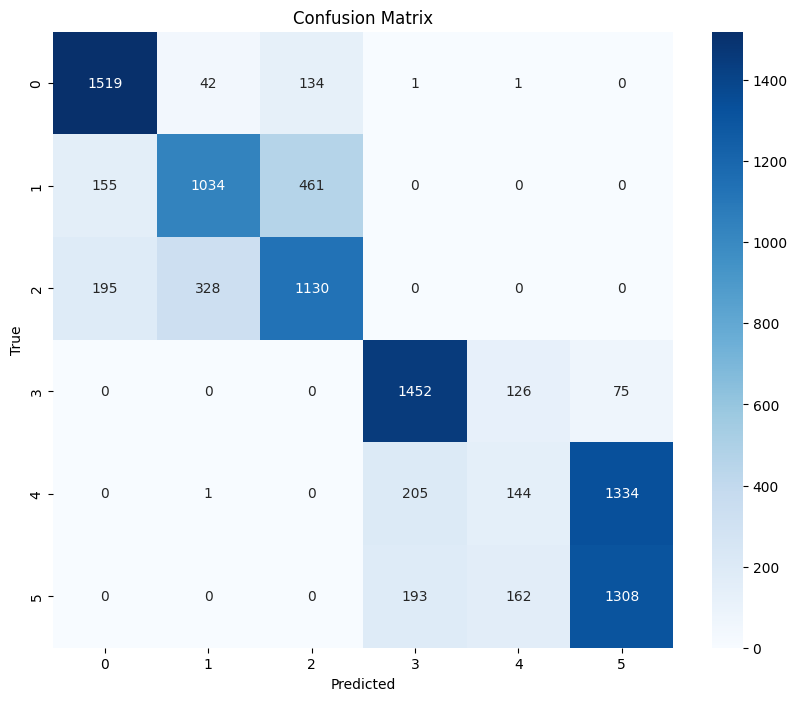

Number of parameters in the model: 525198


In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
chemin_vers_sauvegarde_model = "model2.pth"

path_test = 'test.hdf5'
dataset_test = MyDataset(path_to_data=path_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

trained_model = torch.load(chemin_vers_sauvegarde_model)
trained_model.eval()

# Evaluate the model on the test dataset
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in dataloader_test:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()
        batch_y_predicted = trained_model(batch_x)
        _, preds = torch.max(batch_y_predicted, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on test set: {accuracy:.4f}")

# Calcul du F1-score
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_micro = f1_score(all_labels, all_preds, average='micro')
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (micro): {f1_micro:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=liste_labels, yticklabels=liste_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Model complexity
num_params = count_n_param(trained_model)
print(f"Number of parameters in the model: {num_params}")

In [57]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedModel(nn.Module):
    def __init__(self, input_channels=2, num_classes=6, signal_length=2048):
        super(ImprovedModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * (signal_length // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, T, C) -> (B, C, T)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Instantiate the improved model
device = 'cpu'
improved_model = ImprovedModel(input_channels=2, num_classes=6, signal_length=2048)
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(improved_model.parameters(), weight_decay=1e-4)

n_epochs = 10
chemin_vers_sauvegarde_model = "model3.pth"
improved_model.to(device)

batch_size = 10
path_train = 'train.hdf5'
path_validation = 'validation.hdf5'
dataset_train = MyDataset(path_to_data = path_train)
dataset_validation = MyDataset(path_to_data = path_validation)
dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
dataloader_validation = DataLoader(dataset_validation, batch_size = batch_size, shuffle=True)

loss_train = []
loss_validation = []
early_stopping_patience = 3
best_validation_loss = float('inf')
patience_counter = 0

for epoch in range(n_epochs):
    print(epoch)
    loss_train_epoch = 0.0
    improved_model.train()
    for batch_x, batch_y in dataloader_train:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()
        optimizer.zero_grad()
        batch_y_predicted = improved_model(batch_x)
        l = loss(batch_y_predicted, batch_y)
        l.backward()
        optimizer.step()
        loss_train_epoch = loss_train_epoch + l.item()
    
    loss_train_epoch = loss_train_epoch/len(dataloader_train)
    loss_train.append(loss_train_epoch)
    print("loss_train", loss_train_epoch)

    loss_validation_epoch = 0.0
    improved_model.eval()
    with torch.no_grad():
        for batch_x, batch_y in dataloader_validation:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()
            batch_y_predicted = improved_model(batch_x)
            l = loss(batch_y_predicted, batch_y)
            loss_validation_epoch = loss_validation_epoch + l.item()
    loss_validation_epoch = loss_validation_epoch/len(dataloader_validation)
    loss_validation.append(loss_validation_epoch)
    print("loss_valid", loss_validation_epoch)

    # Early Stopping
    if loss_validation_epoch < best_validation_loss:
        best_validation_loss = loss_validation_epoch
        patience_counter = 0
        torch.save(improved_model.state_dict(), chemin_vers_sauvegarde_model)
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
torch.save(improved_model, chemin_vers_sauvegarde_model)

0
loss_train 1.816112001458804
loss_valid 1.7918994559049606
1
loss_train 1.7925736767053604
loss_valid 1.7917699937820435
2
loss_train 1.7920389722188315
loss_valid 1.7924327189922333
3
loss_train 1.4914337926308314
loss_valid 1.2442916353344917
4
loss_train 1.0993650424381096
loss_valid 0.6875786776840687
5
loss_train 0.8327685563067595
loss_valid 0.6352692406326532
6
loss_train 0.771861408640941
loss_valid 0.6370086462795734
7
loss_train 0.7238775899906953
loss_valid 0.6165086149126291
8
loss_train 0.6713358151465655
loss_valid 0.5770111721009016
9
loss_train 0.6229114530856411
loss_valid 0.5267238943278789


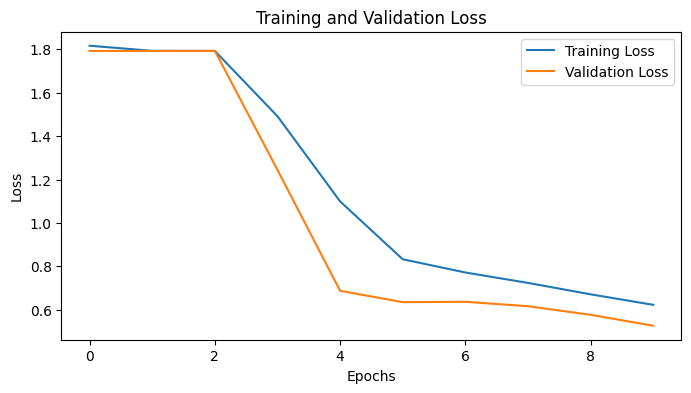

In [59]:
plt.figure(figsize=(8, 4))
plt.plot(range(n_epochs), loss_train, label='Training Loss')
plt.plot(range(n_epochs), loss_validation, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

C:\Users\cyrie\AppData\Local\Temp\ipykernel_16612\579967834.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load(chemin_vers_sauvegarde_model)


Accuracy on test set: 0.6888
F1-score (macro): 0.6916
F1-score (micro): 0.6888


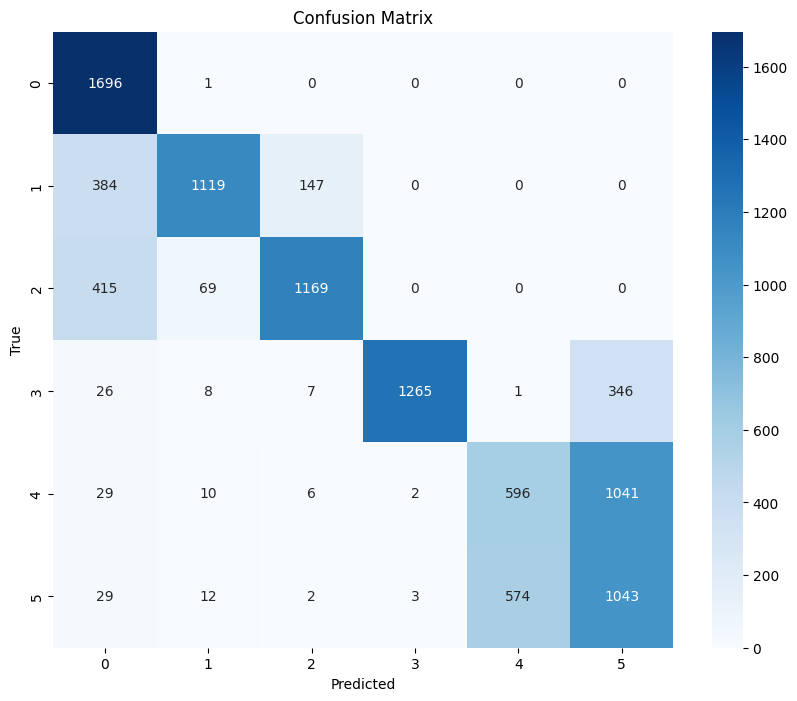

Number of parameters in the model: 2106166


In [60]:
chemin_vers_sauvegarde_model = "model3.pth"

path_test = 'test.hdf5'
dataset_test = MyDataset(path_to_data=path_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

trained_model = torch.load(chemin_vers_sauvegarde_model)
trained_model.eval()

# Evaluate the model on the test dataset
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in dataloader_test:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()
        batch_y_predicted = trained_model(batch_x)
        _, preds = torch.max(batch_y_predicted, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on test set: {accuracy:.4f}")

# Calcul du F1-score
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_micro = f1_score(all_labels, all_preds, average='micro')
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (micro): {f1_micro:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=liste_labels, yticklabels=liste_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Model complexity
num_params = count_n_param(trained_model)
print(f"Number of parameters in the model: {num_params}")